Задание 4.2
Пришло время проанализировать результаты эксперимента, который мы провели вместе с командой дата сайентистов. Эксперимент проходил с 2025-01-31 по 2025-02-06 включительно. Для эксперимента были задействованы 2 и 1 группы. 

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

Ваша задача — проанализировать данные А/B-теста. 

Выбрать метод анализа и сравнить CTR в двух группах (мы разбирали t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).
Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали именно так? 
Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.
Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит. При выполнении задания важно обосновать и аргументировать ваш вывод.
Ваше решение — это ссылка на merge request с проведенным анализом.

In [9]:
import pandahouse
import swifter
import hashlib
import seaborn as sns
import scipy.stats as stats
import numpy as np
import pandas as pd
import matplotlib as plt

In [10]:
#подключение к серверу
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

In [11]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20250120.feed_actions
WHERE toDate(time) between '2025-01-03' and '2025-01-09'
    and exp_group in (2,1)
GROUP BY exp_group, user_id
"""
df = pandahouse.read_clickhouse(q, connection=connection)
df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,39,141,0.276596
4,1,18392,7,32,0.218750


In [12]:
#проводим Т-тест Стьюдента
stats.ttest_ind(df[df.exp_group == 2].ctr,
                df[df.exp_group == 1].ctr,
                equal_var=False)

Ttest_indResult(statistic=-0.4051491913112757, pvalue=0.685373331140751)

In [13]:
print(stats.mannwhitneyu(df[df.exp_group == 2].ctr,
                df[df.exp_group == 1].ctr))

print('Отличие не прокрасилось') 

MannwhitneyuResult(statistic=43777627.0, pvalue=4.632205841806026e-45)
Отличие не прокрасилось


In [14]:
A_gt_B = 0
for _ in range(10000):
    A_gt_B+= df[df.exp_group == 2].ctr.sample().values[0] > df[df.exp_group == 1].ctr.sample().values[0]
    
print('В', A_gt_B/100, '% случаев A > B. Должно получиться около 50%')
#Грузится примерно 10-15 секунд!

В 44.25 % случаев A > B. Должно получиться около 50%


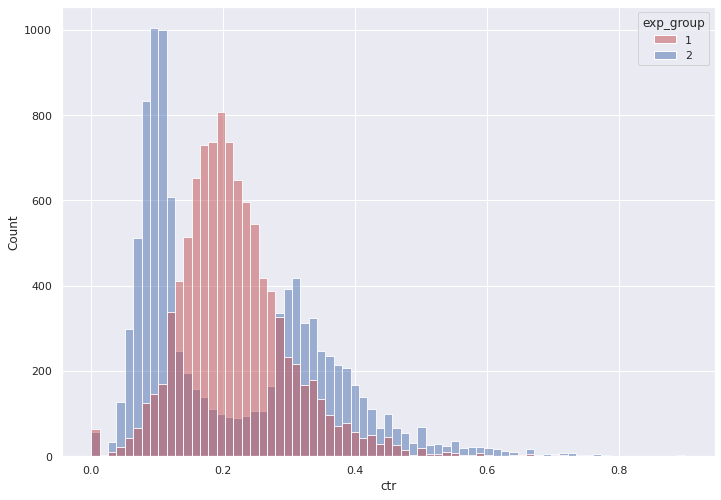

In [15]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

global_ctr_1 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()
global_ctr_2 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()

group1 = df[df.exp_group == 2].copy()
group2 = df[df.exp_group == 1].copy()
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

<Axes: xlabel='smothed_ctr', ylabel='Count'>

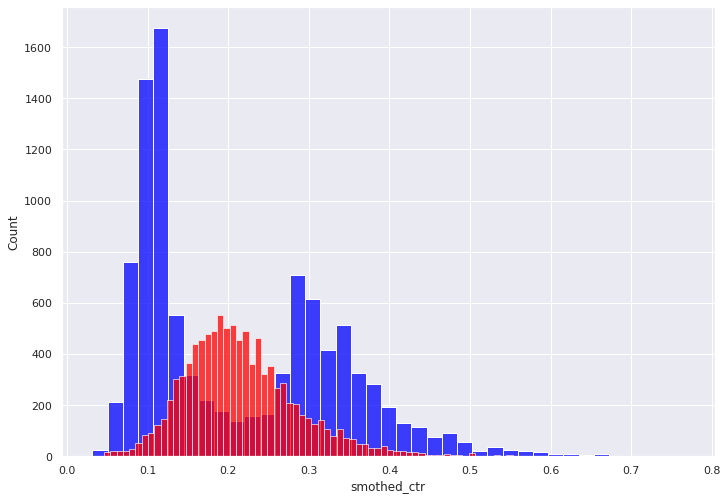

In [16]:
group1['smothed_ctr'] = df[df.exp_group == 2].apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)
group2['smothed_ctr'] = df[df.exp_group == 1].apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

sns.histplot(group1.smothed_ctr, color='blue',
             kde = False)
sns.histplot(group2.smothed_ctr, color='red',
             kde = False)

In [17]:
stats.ttest_ind(group1.smothed_ctr,
                group2.smothed_ctr,
                equal_var=False)

Ttest_indResult(statistic=-1.9460491517027683, pvalue=0.05166679015318526)

In [18]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

<Axes: ylabel='Count'>

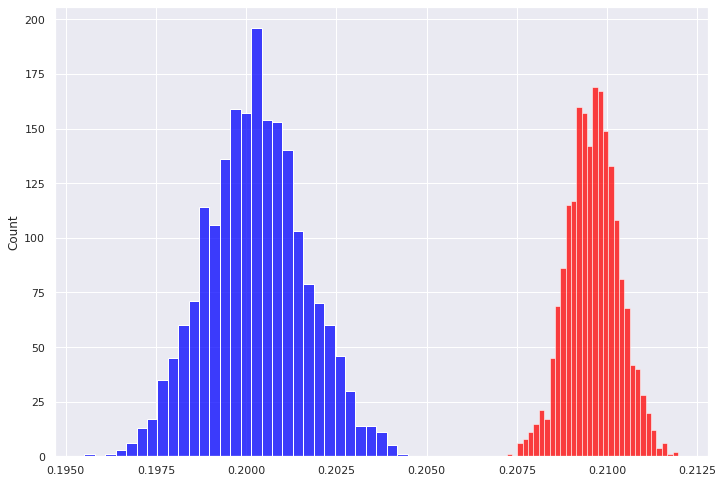

In [20]:
likes1 = df[df.exp_group == 2].likes.to_numpy()
views1 = df[df.exp_group == 2].views.to_numpy()
likes2 = df[df.exp_group == 1].likes.to_numpy()
views2 = df[df.exp_group == 1].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1, color = 'blue')
sns.histplot(ctr2, color = 'red')

<Axes: ylabel='Count'>

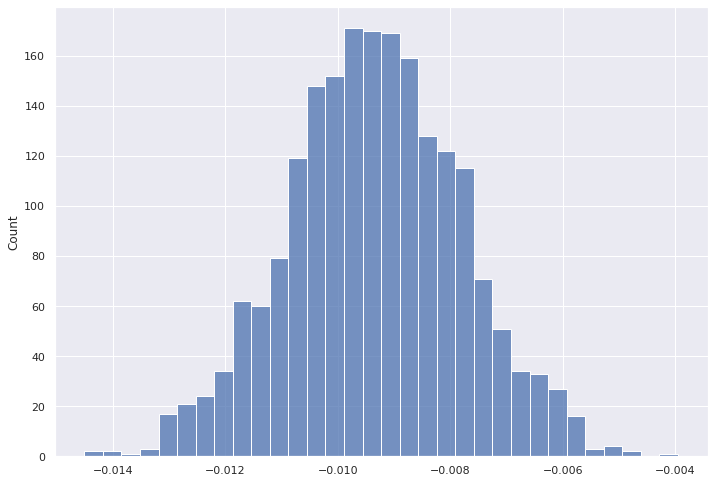

In [21]:
sns.histplot(ctr1 - ctr2)

In [22]:
#Бакетное преобразоваине
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM simulator_20250120.feed_actions
    WHERE toDate(time) between '2025-01-03' and '2025-01-09'
        and exp_group in (2,1)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df = pandahouse.read_clickhouse(q, connection=connection)
df.head()

,exp_group,bucket,bucket_ctr,ctr9
0,1,0,0.200592,0.305556
1,2,0,0.196510,0.385321
2,1,1,0.208799,0.311111
3,2,1,0.210375,0.485714
4,1,2,0.204632,0.314286


<Axes: xlabel='bucket_ctr', ylabel='Count'>

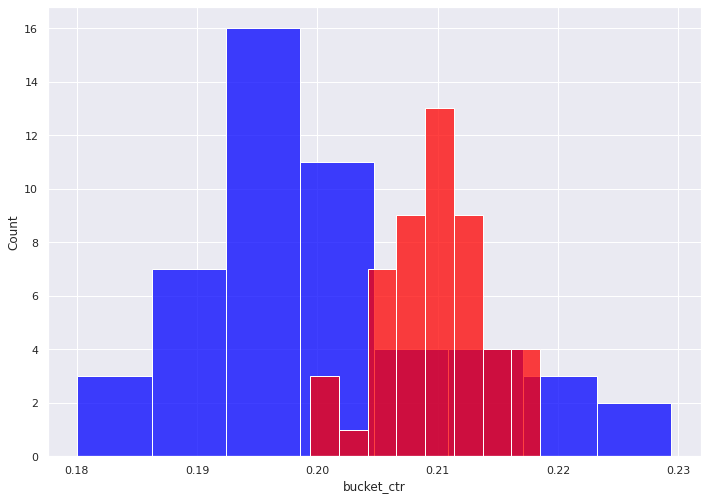

In [26]:
sns.histplot(df[df.exp_group == 2].bucket_ctr, color='blue',
             kde = False)
sns.histplot(df[df.exp_group == 1].bucket_ctr, color='red',
             kde = False)
#таргетированное распределение смещено вправо относительно контрольного

In [24]:
#тест Манна-Уитни видит отличие
stats.mannwhitneyu(df[df.exp_group == 2].bucket_ctr, 
                   df[df.exp_group == 1].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=503.0, pvalue=2.6576427804010095e-07)

In [28]:
#и t-тест тоже

stats.ttest_ind(df[df.exp_group == 2].bucket_ctr, 
                df[df.exp_group == 1].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=-5.614819358149381, pvalue=4.592644937473873e-07)

1. На двух группах проведены все виды тестирования, включая t-тест и тест Манна-Уитни поверх бакетного преобразования) 
2. Т-тест не сработал на сравнении выборок по CTR, т.к. распределение CTR из таргет-группы 2 не является нормальным распределением. Тест Манна-Уитни и все дальнейшие тесты показали что выборки значимо отличаются по показателю CTR. 
3.Распределение CTR из таргет-группы 2 не является нормальным распределением, а именно является двумодальным, т.е. как будто разбивается на два отдельных распределения. Предполагаю, что изменения внесённые в рекомендацию постов подействовали на юзеров в выборке противоположным образом, т.е. для одной из категорий новые рекомендации привели к повышению CTR выше среднего CTR в контрольной группе, в другой категории произошло ровно наоборот. Нужен дальнейший анализ причин такого результата, чтобы понять на какую категорию пользователей было положительное воздействие. 
4. Раскатывать новый алгоритм на всех пользователей неправильно. Нужно провести дополнительный анализ и выяснить у какой категории пользователей новые алгоритмы привели к повышению CTR и возможно раскатить изменения на эту категорию.